In this file I check if learning to map from full rank data to low rank data is a meaningful approach.

I do this by computing the following:

I estimate signal with:
    
    groundtruth_1 := Fully sampled Patient 1

    signal ~ LowRank8(groundtruth_1)
    
    noise ~ shuffling of last 30 FID time steps from different patients ~ 96 in total
    
    groundtruth_2 = signal + noise
    
    Undersampled := undersampled groundtruth_1 (exact same noise)
    
The most reasonable bound on errors is: 

    ||LowRank(groundtruth_1)-LowRank(groundtruth_2)||
if:    
    
    ||LowRank(Undersampled) - LowRank(groundtruth_1)|| < ||LowRank(groundtruth_1)-LowRank(groundtruth_2)||
    
The best the network can hope is learning low rank directly, similar to how it learned IFFT directly;
This will go below the reasonable error threshold by exploiting the reamaining noise that 
 


In [1]:
import os
import sys

sys.path.append('../scripts')
sys.path.append('../models')

os.environ["CUDA_VISIBLE_DEVICES"]= '0' #, this way I would choose GPU 3 to do the work

import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom # for compressing images / only for testing purposes to speed up NN training
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
import torch.nn as nn
from data_preparation import *
from data_undersampling import *
from output_statistics import *

from interlacer_layer_modified import *
from Residual_Interlacer_modified import *
from skimage.metrics import structural_similarity as ssim 

MASKS = np.load('../data/masks.npy')

grouped_time_steps = 1 # Set how many subsequent time steps you want to give to the network at once. Values allowed: 1, 2, 4, 8 (because it has to divide 8)

# ***Possoin undersampling***

In [10]:
trancuate_t = 96
Patient = 0
AF = 3

Ground_Truth = np.load('../data/Full_Rank_All_trancuated_k_space_masked.npy')
Undersampled_Data = np.load(f'../data/Undersampled_Data_P03-P08/Undersampled_possoin_3D_fixed_r0_AF_{AF}.npy')
    
#noise = Ground_Truth[...,Patient]-low_rank(Undersampled_Data[..., Patient], 8)
noise = np.concatenate([Ground_Truth[:,:,:,66:,:,1], Ground_Truth[:,:,:,66:,:,2], Ground_Truth[:,:,:,66:,:,3], Ground_Truth[:,:,:,90:,:,4]], axis=3)  
axis_to_shuffle = 3
shuffled_indices = np.random.permutation(noise.shape[axis_to_shuffle])
noise = np.take(noise, shuffled_indices, axis=axis_to_shuffle)
 
Ground_Truth_L8 = low_rank(Ground_Truth[..., Patient], 8)    #np.fft.fftshift(np.fft.fft(Ground_Truth, axis=-3),axes=-3)

Ground_Truth_2 = Ground_Truth_L8 + noise
Ground_Truth_2_L8 = low_rank(Ground_Truth_2, 8)  

Undersampled_L8 = low_rank(Undersampled_Data[..., Patient], 8)    #np.fft.fftshift(np.fft.fft(Undersampled_Data, axis=-3),axes=-3)

Ground_Truth_2_Spectral = np.fft.fftshift(np.fft.fft(Ground_Truth_2, axis=-2),axes=-2)
Ground_Truth_2_Spectral_L8 = np.fft.fftshift(np.fft.fft(Ground_Truth_2_L8, axis=-2),axes=-2)
Ground_Truth_Spectral = np.fft.fftshift(np.fft.fft(Ground_Truth[..., Patient], axis=-2),axes=-2)
Ground_Truth_Spectral_L8 = np.fft.fftshift(np.fft.fft(Ground_Truth_L8, axis=-2),axes=-2)

Undersampled_Data_Spectral = np.fft.fftshift(np.fft.fft(Undersampled_Data[..., Patient], axis=-2),axes=-2)
Undersampled_Data_Spectral_L8 = np.fft.fftshift(np.fft.fft(Undersampled_L8, axis=-2),axes=-2)

In [ ]:
# in this cell I compute the error of LR8(noise directly and compute it to the error )

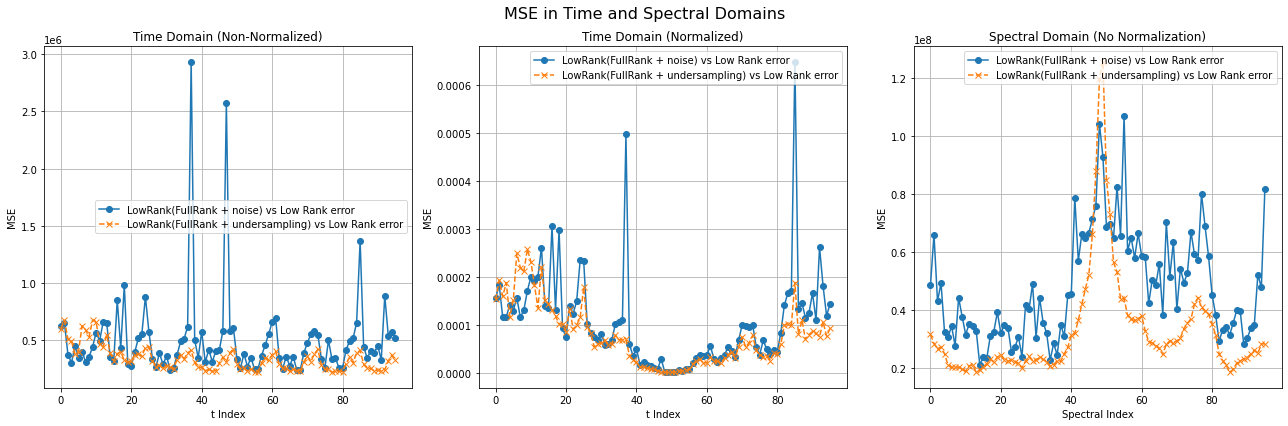

==== Model Output vs Ground Truth ====
Total MSE in image domain: 248658.62913106277
Normalized Total MSE in image domain: 5.255172153707629e-05
Total MSE in spectral domain: 23871228.396582026

==== Model Input vs Ground Truth ====
Total MSE in image domain: 169135.7228699477
Normalized Total MSE in image domain: 3.936191724281169e-05
Total MSE in spectral domain: 16237029.39551498


In [11]:
label = 'LowRank(FullRank + noise) vs Low Rank error'
label2 ='LowRank(FullRank + undersampling) vs Low Rank error'


_, _, norm_values_test = normalize_data_per_image_new(Ground_Truth_2_Spectral_L8, Ground_Truth_L8)

plot_general_statistics(Ground_Truth_2_L8, Undersampled_L8, Ground_Truth_L8, 96, norm_values_test, label, label2)
#plot_general_statistics_PSNR(Ground_Truth_noisy, Undersampled_Signal_no_noise, Signal_Estimate, 96, norm_values_test, label2, label)
#plot_general_statistics_SSIM(Ground_Truth_noisy, Undersampled_Signal_no_noise, Signal_Estimate, 96, norm_values_test, label2, label)

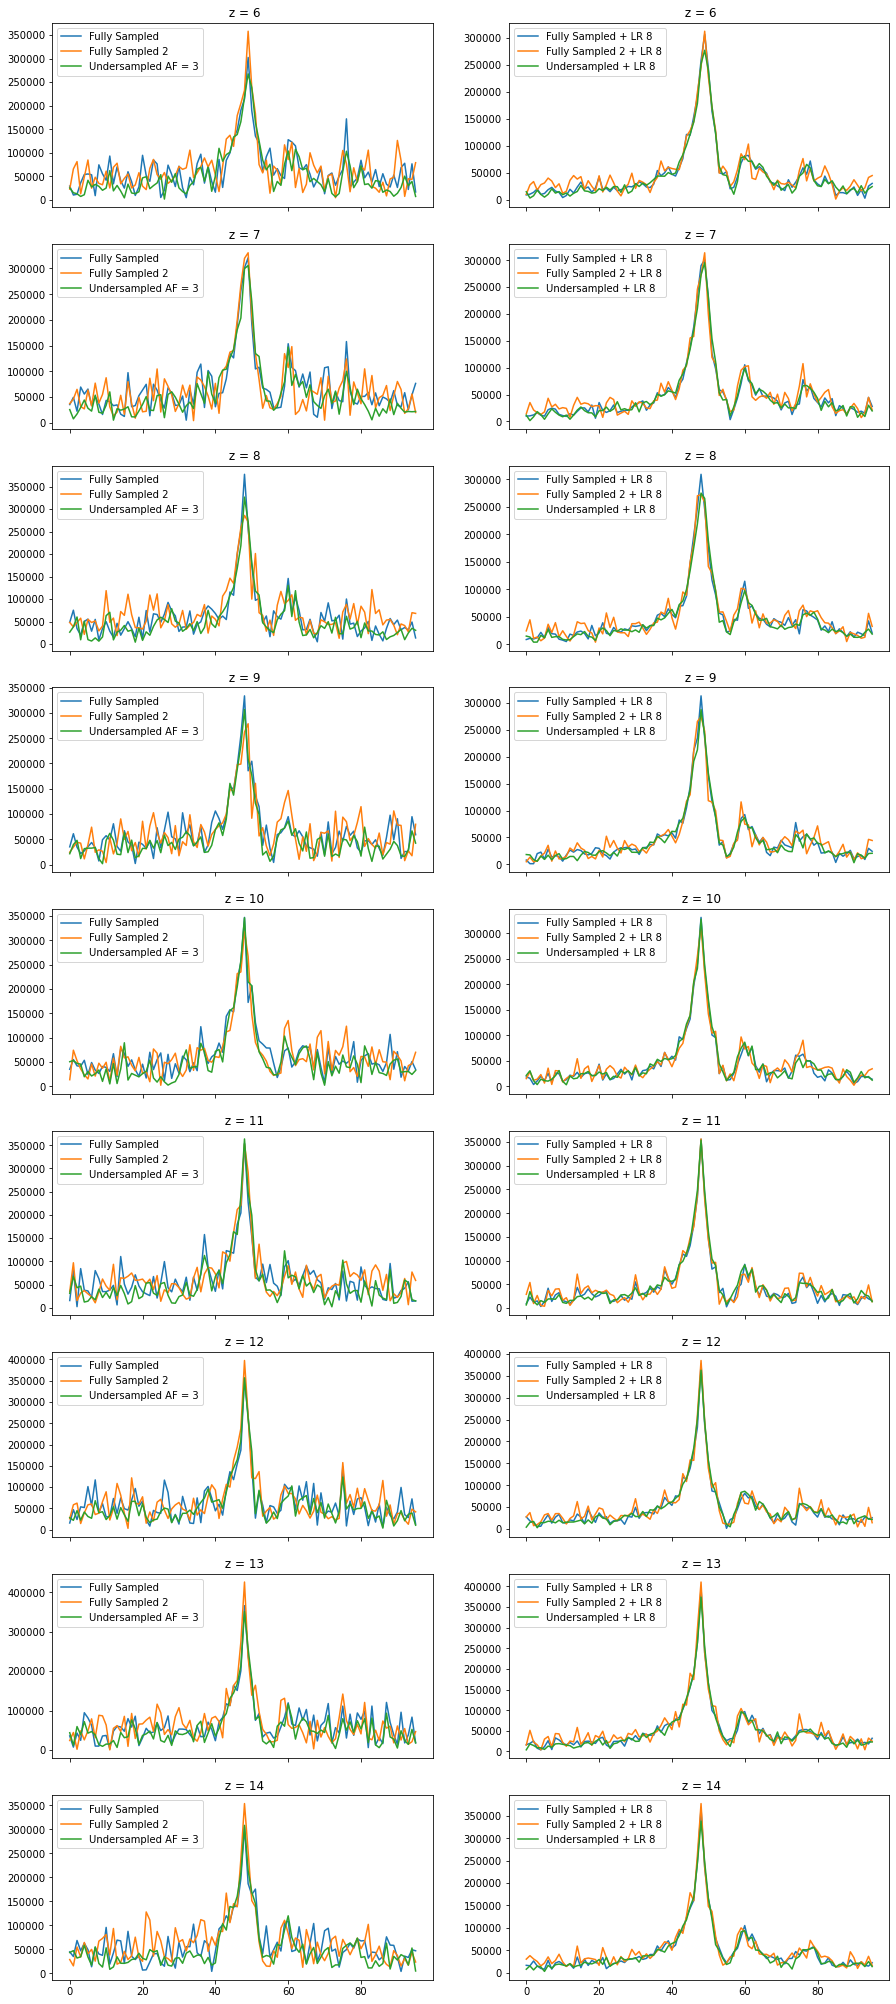

In [4]:
Patient = 0
x, y, T = 10, 15, 5

indices = range(6, 15) 
num_rows = len(indices)
num_cols = 2  # left column: arr1 vs arr2; right column: arr3 vs arr4
# Create a figure and a grid of subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 4), sharex=True)

# If there's only one row, axs may not be 2D, so ensure we have a 2D array:
if num_rows == 1:
    axs = np.array([axs])

for i, idx in enumerate(indices):
    # Left subplot: compare arr1 and arr2
    ax_left = axs[i, 0]
    ax_left.plot(np.abs(Ground_Truth_Spectral[x, y, idx, :, T]), label="Fully Sampled")
    ax_left.plot(np.abs(Ground_Truth_2_Spectral[x, y, idx, :, T]), label="Fully Sampled 2")
    ax_left.plot(np.abs(Undersampled_Data_Spectral[x, y, idx, :, T]), label=f"Undersampled AF = {AF}")
    ax_left.set_title(f" z = {idx}")
    ax_left.legend()
    ax_left.legend(loc="upper left")
    
    # Right subplot: compare arr3 and arr4
    ax_right = axs[i, 1]
    ax_right.plot(np.abs(Ground_Truth_Spectral_L8[x, y, idx, :, T]), label="Fully Sampled + LR 8")
    ax_right.plot(np.abs(Ground_Truth_2_Spectral_L8[x, y, idx, :, T]), label="Fully Sampled 2 + LR 8")
    ax_right.plot(np.abs(Undersampled_Data_Spectral_L8[x, y, idx, :, T]), label="Undersampled + LR 8")
    ax_right.set_title(f" z = {idx}")
    ax_right.legend()
    ax_right.legend(loc="upper left")


# **Regular Undersampling**

In [5]:
Dataset = 'FullRank' # Options: FullRank, SpectralFit, LowRank
trancuate_t = 96
Patient = 0
AF = 3

Ground_Truth = np.load('../data/Full_Rank_All_trancuated_k_space_masked.npy')
Undersampled_Data = np.load(f'../data/Undersampled_Data_P03-P08/Undersampled_Regular.npy')
    
#noise = Ground_Truth[...,Patient]-low_rank(Undersampled_Data[..., Patient], 8)
noise = np.concatenate([Ground_Truth[:,:,:,66:,:,1], Ground_Truth[:,:,:,66:,:,2], Ground_Truth[:,:,:,66:,:,3], Ground_Truth[:,:,:,90:,:,4]], axis=3)  
axis_to_shuffle = 3
shuffled_indices = np.random.permutation(noise.shape[axis_to_shuffle])
noise = np.take(noise, shuffled_indices, axis=axis_to_shuffle)
 
Ground_Truth_L8 = low_rank(Ground_Truth[..., Patient], 8)    #np.fft.fftshift(np.fft.fft(Ground_Truth, axis=-3),axes=-3)

Ground_Truth_2 = Ground_Truth_L8 + noise
Ground_Truth_2_L8 = low_rank(Ground_Truth_2, 8)  

Undersampled_L8 = low_rank(Undersampled_Data[..., Patient], 8)    #np.fft.fftshift(np.fft.fft(Undersampled_Data, axis=-3),axes=-3)

Ground_Truth_2_Spectral = np.fft.fftshift(np.fft.fft(Ground_Truth_2, axis=-2),axes=-2)
Ground_Truth_2_Spectral_L8 = np.fft.fftshift(np.fft.fft(Ground_Truth_2_L8, axis=-2),axes=-2)
Ground_Truth_Spectral = np.fft.fftshift(np.fft.fft(Ground_Truth[..., Patient], axis=-2),axes=-2)
Ground_Truth_Spectral_L8 = np.fft.fftshift(np.fft.fft(Ground_Truth_L8, axis=-2),axes=-2)

Undersampled_Data_Spectral = np.fft.fftshift(np.fft.fft(Undersampled_Data[..., Patient], axis=-2),axes=-2)
Undersampled_Data_Spectral_L8 = np.fft.fftshift(np.fft.fft(Undersampled_L8, axis=-2),axes=-2)

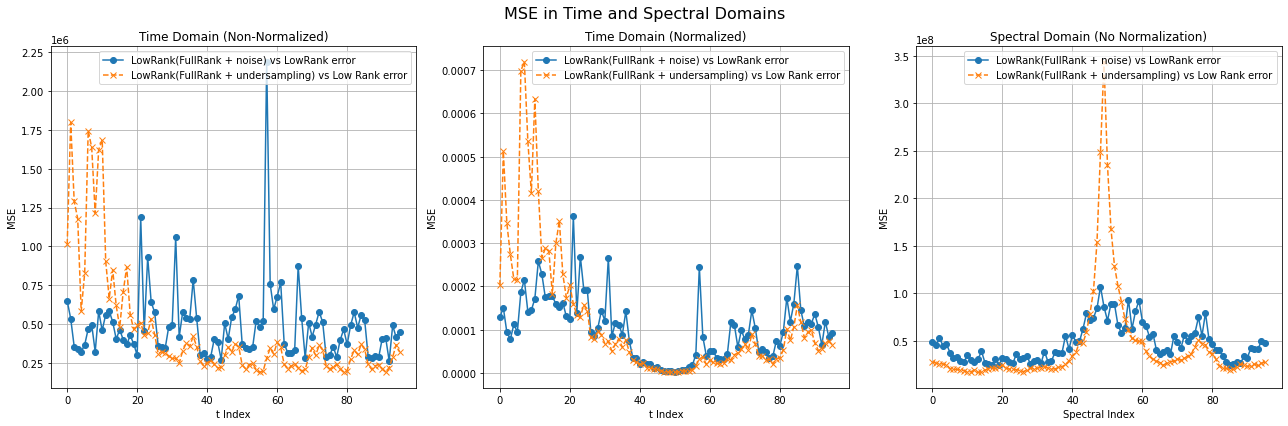

==== Model Output vs Ground Truth ====
Total MSE in image domain: 242833.3727886749
Normalized Total MSE in image domain: 5.105586045226038e-05
Total MSE in spectral domain: 23312003.787712786

==== Model Input vs Ground Truth ====
Total MSE in image domain: 222954.43436775228
Normalized Total MSE in image domain: 5.960445530062344e-05
Total MSE in spectral domain: 21403625.699304216


In [6]:
label = 'LowRank(FullRank + noise) vs LowRank error'
label2 ='LowRank(FullRank + undersampling) vs Low Rank error'


_, _, norm_values_test = normalize_data_per_image_new(Ground_Truth_2_Spectral_L8, Ground_Truth_L8)

plot_general_statistics(Ground_Truth_2_L8, Undersampled_L8, Ground_Truth_L8, 96, norm_values_test, label, label2)
#plot_general_statistics_PSNR(Ground_Truth_noisy, Undersampled_Signal_no_noise, Signal_Estimate, 96, norm_values_test, label2, label)
#plot_general_statistics_SSIM(Ground_Truth_noisy, Undersampled_Signal_no_noise, Signal_Estimate, 96, norm_values_test, label2, label)

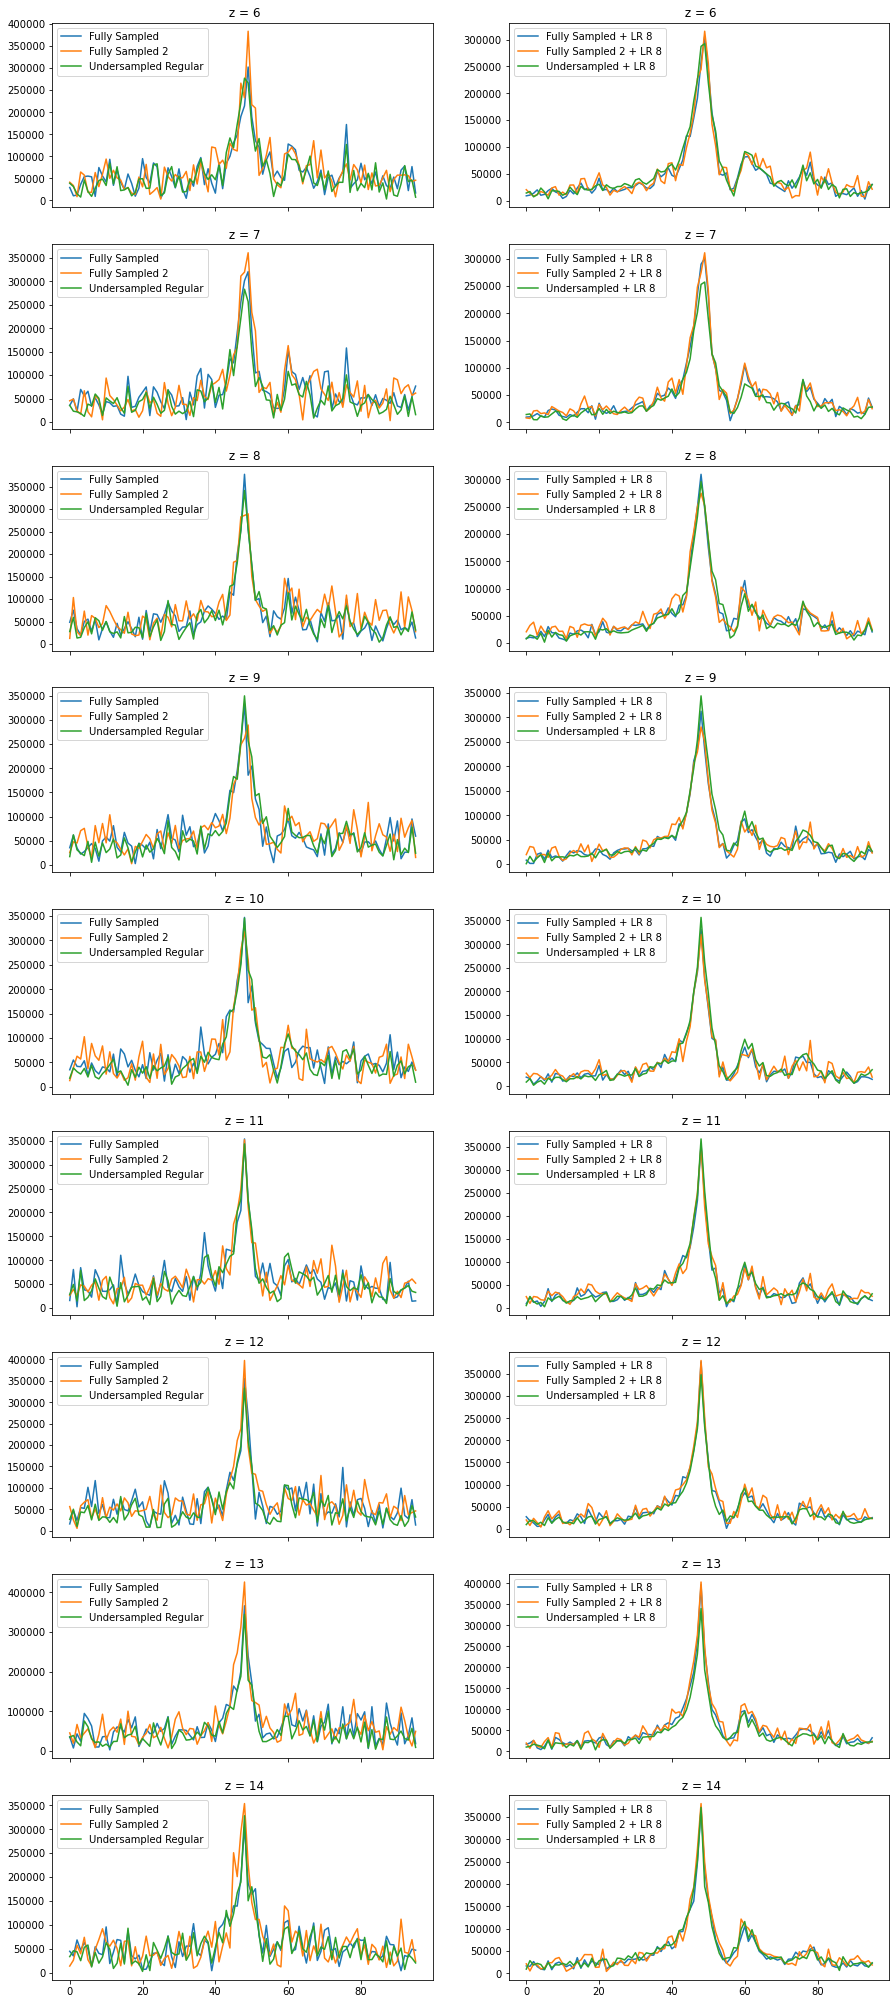

In [7]:
Patient = 0
x, y, T = 10, 15, 5

indices = range(6, 15) 
num_rows = len(indices)
num_cols = 2  # left column: arr1 vs arr2; right column: arr3 vs arr4
# Create a figure and a grid of subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 4), sharex=True)

# If there's only one row, axs may not be 2D, so ensure we have a 2D array:
if num_rows == 1:
    axs = np.array([axs])

for i, idx in enumerate(indices):
    # Left subplot: compare arr1 and arr2
    ax_left = axs[i, 0]
    ax_left.plot(np.abs(Ground_Truth_Spectral[x, y, idx, :, T]), label="Fully Sampled")
    ax_left.plot(np.abs(Ground_Truth_2_Spectral[x, y, idx, :, T]), label="Fully Sampled 2")
    ax_left.plot(np.abs(Undersampled_Data_Spectral[x, y, idx, :, T]), label=f"Undersampled Regular")
    ax_left.set_title(f" z = {idx}")
    ax_left.legend()
    ax_left.legend(loc="upper left")
    
    # Right subplot: compare arr3 and arr4
    ax_right = axs[i, 1]
    ax_right.plot(np.abs(Ground_Truth_Spectral_L8[x, y, idx, :, T]), label="Fully Sampled + LR 8")
    ax_right.plot(np.abs(Ground_Truth_2_Spectral_L8[x, y, idx, :, T]), label="Fully Sampled 2 + LR 8")
    ax_right.plot(np.abs(Undersampled_Data_Spectral_L8[x, y, idx, :, T]), label="Undersampled + LR 8")
    ax_right.set_title(f" z = {idx}")
    ax_right.legend()
    ax_right.legend(loc="upper left")